# 포트폴리오 최적화

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 주가 데이터 수집

In [19]:
import pandas_datareader.data as wb

symbols = ['AAPL', 'MSFT', 'YHOO', 'DB', 'GLD']
noa = len(symbols)
data = pd.DataFrame()
for sym in symbols:
    data[sym] = wb.DataReader(sym, data_source='yahoo',
                              end='2014-09-12')['Adj Close']
data.columns = symbols
data.tail()

,AAPL,MSFT,YHOO,DB,GLD
Date,,,,,
2014-09-08,95.195338,44.324409,41.810001,34.039067,120.730003
2014-09-09,94.837239,44.601017,40.779999,33.834365,120.870003
2014-09-10,97.750397,44.677325,41.139999,34.399735,120.260002
2014-09-11,98.166562,44.829937,41.259998,34.360744,119.470001
2014-09-12,98.389165,44.543790,42.880001,34.146292,118.379997


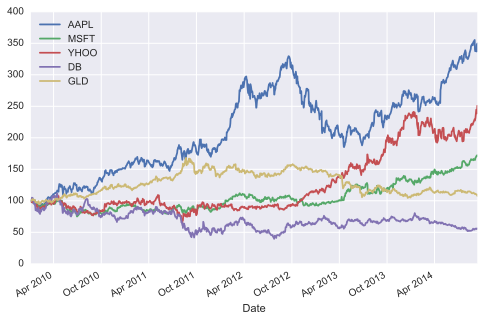

In [20]:
(data / data.ix[0] * 100).plot(figsize=(8, 5), grid=True)
plt.show()

## 수익률 계산

In [15]:
rets = np.log(data / data.shift(1))
rets.mean() * 252

AAPL    0.267080
MSFT    0.114505
YHOO    0.196165
DB     -0.125174
GLD     0.016054
dtype: float64

In [16]:
rets.cov() * 252

,AAPL,MSFT,YHOO,DB,GLD
AAPL,0.072784,0.020459,0.023243,0.041027,0.005231
MSFT,0.020459,0.049402,0.024244,0.046089,0.002105
YHOO,0.023243,0.024244,0.093349,0.051538,-0.000864
DB,0.041027,0.046089,0.051538,0.177517,0.008777
GLD,0.005231,0.002105,-0.000864,0.008777,0.032406


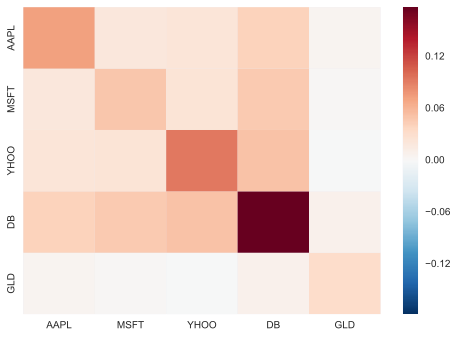

In [22]:
sns.heatmap(rets.cov() * 252)
plt.show()

## 포트폴리오 이론

* 각 자산의 수익률이 $r_i$이고 자산 비중이 $w_i$이면


* 포트폴리오 수익률은 
$$ 
\begin{eqnarray}
\mu_p 
&=& \text{E} [r_p] \\
&=& \text{E} \left[ \sum_i w_i r_i \right] \\
&=& \sum_i w_i \text{E} [r_i] \\
&=& \sum_i w_i \mu_i \\
&=& w^T \mu
\end{eqnarray}
$$
이 식에서 $\mu$ 는 자산의 기대 수익률 벡터


* 포트폴리오 분산은 
$$ 
\begin{eqnarray}
\sigma_p^2 
&=& \text{E} \left[ (r_p - \mu_p)^2 \right] \\
&=& \text{E} \left[ (w^T r - w^T \mu)^2 \right] \\
&=& \text{E} \left[ w^T(r-\mu)(r-\mu)^Tw \right] \\
&=& w^T \text{E} \left[ (r-\mu)(r-\mu)^T \right] w \\
&=& w^T \Sigma w  
\end{eqnarray}
$$
이 식에서 $\Sigma$ 는 자산 수익률의 공분산 행렬

In [28]:
np.random.seed(2)
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.23349275,  0.01388454,  0.2943663 ,  0.2331326 ,  0.22512381])

In [29]:
np.sum(rets.mean() * weights) * 252

0.09612740192056152

In [27]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.040091365274925586

In [30]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.20022828290460262

## 포트폴리오 수익률 시뮬레이션

In [31]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

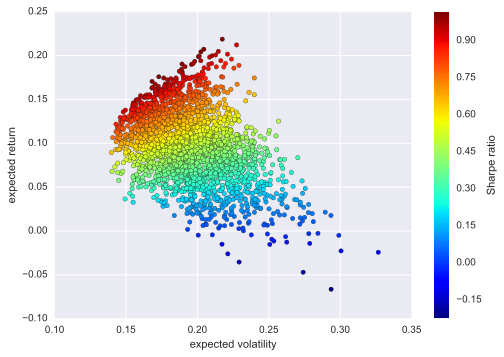

In [36]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

## 포트폴리오 통계

* 수익률, 변동성, 샤프 지수 계산

In [37]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        포트폴리오 내의 증권 비중
    
    Returns
    =======
    pret : float
        포트폴리오 수익률의 기댓값
    pvol : float
        포트폴리오 변동성의 기댓값
    pret / pvol : float
        무위험 이자율이 0일 때의 포트폴리오 샤프 지수
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

## 샤프 지수 최대화

In [38]:
import scipy.optimize as sco

In [39]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [40]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

In [42]:
bnds = tuple((0, 1) for x in range(noa))
bnds

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [43]:
noa * [1. / noa,]

[0.2, 0.2, 0.2, 0.2, 0.2]

In [44]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 39.6 ms


In [45]:
opts

     fun: -1.0630084836641971
     jac: array([ -1.82956457e-04,  -7.02306628e-04,   7.18027353e-04,
         1.51409782e+00,   1.54867768e-03,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([  6.61851751e-01,   8.64634623e-02,   2.51684786e-01,
         0.00000000e+00,   2.72744609e-17])

In [46]:
opts['x'].round(3)

array([ 0.662,  0.086,  0.252,  0.   ,  0.   ])

In [47]:
statistics(opts['x']).round(3)

array([ 0.236,  0.222,  1.063])

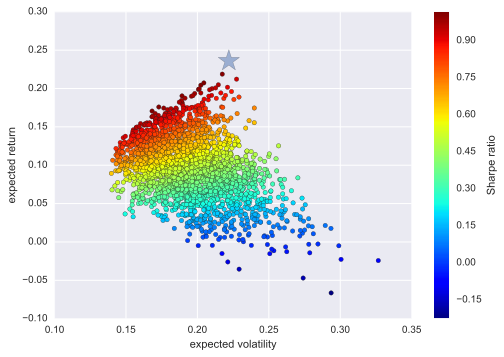

In [73]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5)
plt.show()

## 포트폴리오 분산 최소화

In [57]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [58]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [59]:
optv

     fun: 0.018288000843087016
     jac: array([ 0.03637058,  0.03644131,  0.03614311,  0.05221011,  0.03676901,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([ 0.10760186,  0.24894006,  0.10931005,  0.        ,  0.53414802])

In [60]:
optv['x'].round(3)

array([ 0.108,  0.249,  0.109,  0.   ,  0.534])

In [61]:
statistics(optv['x']).round(3)

array([ 0.087,  0.135,  0.645])

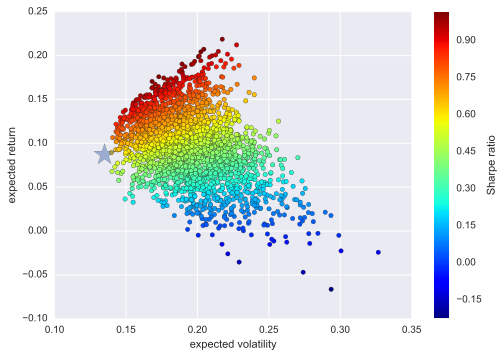

In [72]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=mpl.cm.jet)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_optv = statistics(optv['x']).round(3)
plt.scatter(pt_optv[1], pt_optv[0], marker="*", s=500, alpha=0.5)
plt.show()

## 효율적 투자선

* 목표 위험 수준에 대해 최대 수익률을 가지는 모든 포트폴리오의 집합

In [67]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [68]:
def min_func_port(weights):
    return statistics(weights)[1]

In [69]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 2.79 s, sys: 0 ns, total: 2.79 s
Wall time: 2.8 s


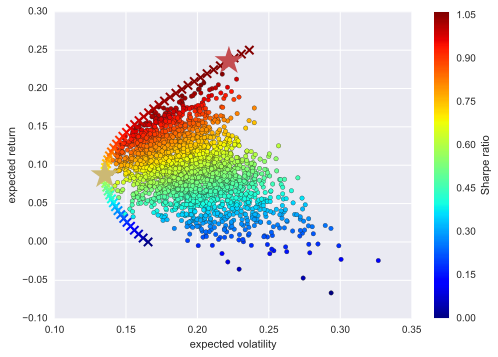

In [87]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap=mpl.cm.jet)
            # 무작위 포트폴리오
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x', s=70, linewidth=2, cmap=mpl.cm.jet)
            # 효율적 투자선
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=30)
            # 최대 샤프 지수를 가진 포트폴리오
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=30)
            # 최소 분산 포트폴리오
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

## 스플라인 함수화

In [88]:
import scipy.interpolate as sci

In [89]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [90]:
tck = sci.splrep(evols, erets)

In [92]:
def f(x):
    ''' 효율적 투자선 함수 (스플라인 근사) '''
    return sci.splev(x, tck, der=0)

def df(x):
    ''' 효율적 투자선 함수의 1차 도함수 '''
    return sci.splev(x, tck, der=1)

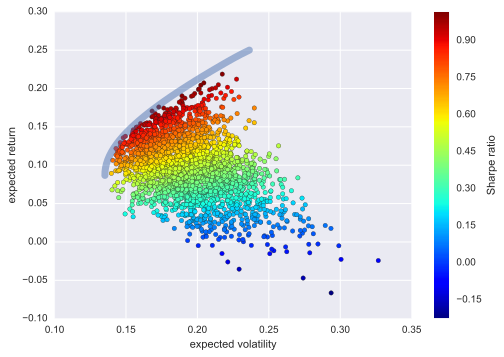

In [97]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap=mpl.cm.jet)
            # 무작위 포트폴리오

plt.plot(evols, f(evols), lw=7, alpha=0.5)    

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

## 자본시장선

* 무위험 자산을 포함한 최적 포트폴리오 집합
* 무위험 자산을 지나며 효율적 투자선 $f(x)$에 접하는 직선 $t(x)$
$$ t(x) = a + bx $$
$$ t(0) = r_f $$
$$ t(x) = f(x) $$
$$ t'(x) = f'(x) $$

In [98]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [99]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])
opt

array([ 0.01      ,  1.0183289 ,  0.22606876])

In [100]:
np.round(equations(opt), 6)

array([ 0.,  0.,  0.])

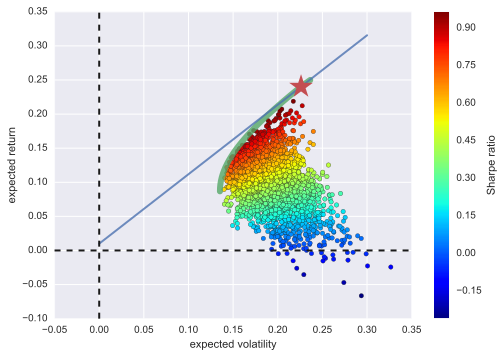

In [106]:
plt.scatter(pvols, prets,
            c=(prets - 0.01) / pvols, marker='o', cmap=mpl.cm.jet)
            # 무작위 포트폴리오
plt.plot(evols, erets, 'g', lw=6, alpha=0.8)
            # 효율적 투자선
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=2, alpha=0.8)
            # 자본 시장선
plt.plot(opt[2], f(opt[2]), 'r*', markersize=25.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [107]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
res['x'].round(3)

array([ 0.687,  0.057,  0.256,  0.   ,  0.   ])